In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%pwd

'/content'

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

# This is in my google drive
train_dataset_directory = '/content/drive/MyDrive/Dataset/train/train'
test_dataset_directory = '/content/drive/MyDrive/Dataset/test/test'

training_dataset = image_dataset_from_directory(train_dataset_directory,                                         
                                             batch_size=32,
                                             image_size=(224, 224),
                                             seed = 42,
                                             subset= 'training',
                                             validation_split=0.2) # 20% of data will be used for validation)                        https://stackoverflow.com/questions/58565394/what-is-the-difference-between-sparse-categorical-crossentropy-and-categorical-c

validation_datset = image_dataset_from_directory(train_dataset_directory,
                                              validation_split=0.2, # 20% of data will be used for validation
                                              subset='validation',
                                              seed=42, # random number shuffler of data. Same as training for consistency
                                              image_size=(224, 224),
                                              batch_size=32)

test_dataset = image_dataset_from_directory(test_dataset_directory,                                         
                                             batch_size=32,
                                             image_size=(224, 224)) 



class_names = training_dataset.class_names
print(class_names)


Found 993 files belonging to 3 classes.
Using 795 files for training.
Found 993 files belonging to 3 classes.
Using 198 files for validation.
Found 267 files belonging to 3 classes.
['paper', 'plastic', 'trash']


In [ ]:
from tensorflow.data.experimental import AUTOTUNE

# Allows the system to automatiucally determine optimal buffer size. May help improve traininng speed
training_dataset = training_dataset.prefetch(buffer_size=AUTOTUNE) 

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom, RandomTranslation
from tensorflow.keras import Sequential
# data augeentation here. https://www.tensorflow.org/tutorials/images/data_augmentation#data_augmentation_2

# Data augmentation layers. This does NOT increase the amount of data. Instead it augements on the Fly
# Meaning during training the model will randomly see the data rotated, flipped, zoomed or translated
data_augmentation = Sequential([
    RandomRotation(0.1),
    RandomFlip("horizontal"),
    RandomZoom(0.1),
    RandomTranslation(0.1, 0.1),
])


train_ds = training_dataset.map(lambda images, labels: (data_augmentation(images), labels))
print(train_ds)


<_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [ ]:
# pre process input 
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# pre-processes by the mean and standard deviation of certain values, while making the pixels be between [-1,1] See here https://pytorch.org/hub/pytorch_vision_mobilenet_v2/
train_ds = training_dataset.map(lambda images, labels: (preprocess_input(images), labels))
val_ds = validation_datset.map(lambda images, labels: (preprocess_input(images), labels))
test_dataset = test_dataset.map(lambda images, labels: (preprocess_input(images), labels))

In [ ]:
from keras.applications import MobileNetV2
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense
from keras.models import Model
from keras import regularizers


# Import pretrained model on ImageNet. Keep input shape same as ImageNet. Dont include classification layer
model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
model.trainable = None # freeze the weights

# Retrieve the last layer
last_layer_output = model.output

# Add the Pooling layer on top (why? The default mobileNetV2 has one. We are using it as a custom fit) 
pooling_features = GlobalAveragePooling2D()(last_layer_output)

# Adds a fully connected layer. using an L2 Regularizer
dense_layer_output = Dense(1024, activation='relu', kernel_regularizer = regularizers.l2(0.01))(pooling_features)

# Another Fully Connected layer on top. value of 3 because we have 3 classes [paper, plastic, trash]
prediction_output = Dense(3, activation='softmax', kernel_regularizer = regularizers.l2(0.01))(dense_layer_output)

model = Model(inputs=model.input, outputs=prediction_output)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [ ]:
# Standard params. Adam and sparse loss are community defaults
from keras.optimizers.adam import Adam

# default learning rate is 0.001. Lowering it to improve training data
adam = Adam(learning_rate = 0.0001) 
model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_ds,
    epochs=40,
    validation_data=val_ds,
    verbose = 2,
    batch_size = len(train_ds)) # uses BGD instead of SGD

"""
Validation loss improved slighlty and oscillated. The learning rate might be too high. 
Solution: test with a smaller learning rate

Consider using BGD as the batch size. Ideal for data less than 2000. To use BGD

"""

Epoch 1/40
25/25 - 7s - loss: 11.7803 - accuracy: 0.7421 - val_loss: 11.1901 - val_accuracy: 0.8737 - 7s/epoch - 288ms/step
Epoch 2/40
25/25 - 3s - loss: 10.7828 - accuracy: 0.9006 - val_loss: 10.4275 - val_accuracy: 0.9040 - 3s/epoch - 103ms/step
Epoch 3/40
25/25 - 3s - loss: 10.0065 - accuracy: 0.9384 - val_loss: 9.7064 - val_accuracy: 0.9040 - 3s/epoch - 105ms/step
Epoch 4/40
25/25 - 3s - loss: 9.2836 - accuracy: 0.9560 - val_loss: 9.0299 - val_accuracy: 0.9040 - 3s/epoch - 120ms/step
Epoch 5/40
25/25 - 3s - loss: 8.5950 - accuracy: 0.9686 - val_loss: 8.3837 - val_accuracy: 0.9091 - 3s/epoch - 104ms/step
Epoch 6/40
25/25 - 3s - loss: 7.9384 - accuracy: 0.9836 - val_loss: 7.7694 - val_accuracy: 0.9141 - 3s/epoch - 104ms/step
Epoch 7/40
25/25 - 3s - loss: 7.3303 - accuracy: 0.9887 - val_loss: 7.2012 - val_accuracy: 0.9040 - 3s/epoch - 132ms/step
Epoch 8/40
25/25 - 3s - loss: 6.7598 - accuracy: 0.9899 - val_loss: 6.6551 - val_accuracy: 0.9040 - 3s/epoch - 126ms/step
Epoch 9/40
25/25 - 

'\nValidation loss improved slighlty and oscillated. The learning rate might be too high. \nSolution: test with a smaller learning rate\n\nConsider using BGD as the batch size. Ideal for data less than 2000. To use BGD\n\n'

In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')


9/9 [==============================] - 1s 49ms/step - loss: 0.6763 - accuracy: 0.9101
Test accuracy: 91.01%


In [ ]:
model.save('/content/drive/MyDrive//mobileNetV2.h5')
# previous save saved somewhere i dont know

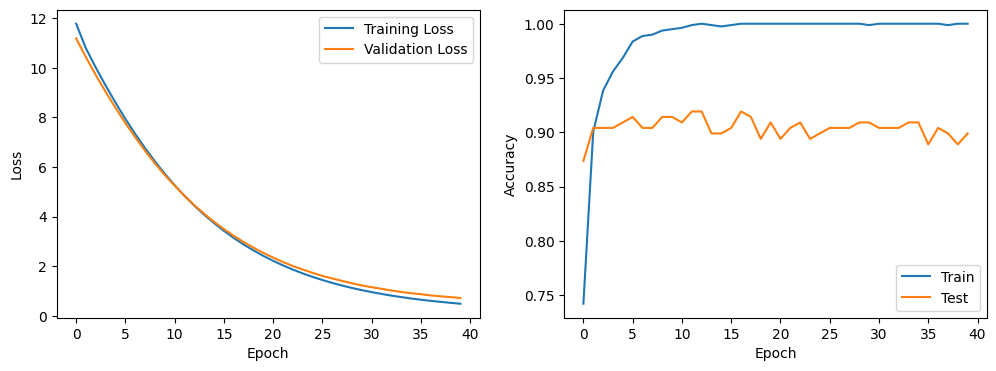

'\nGraph one shows that the model is learning, mbut failed to generalize on the validation.\nThis is a form of overfitting the data. Our model is too complex for our data.\n\nSolutions: Obtain more data to avoid overfitting or perform overfitting techniques\n'

In [ ]:
import matplotlib.pyplot as plt

# Plot the training/validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot the training/validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

"""
Graph one shows that the model is learning, mbut failed to generalize on the validation.
This is a form of overfitting the data. Our model is too complex for our data.

Solutions: Obtain more data to avoid overfitting or perform overfitting techniques
"""